# Krwinki - segmentacja - k-spójność #


## Import bibliotek##

In [1]:
from PIL import Image

from skimage import io
import cv2

import numpy as np
import networkx as nx
from graphviz import Graph
from networkx.algorithms import approximation as apxa
from random import randint
import matplotlib.pyplot as plt

## 1. Wczytywanie obrazu ##

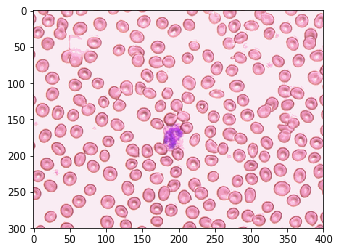

In [2]:
image = Image.open("red_blood_cells.png")
plt.imshow(image)
plt.show()

In [3]:
print(image.size)

(400, 300)


Teraz należy przekształcić obraz do postaci macierzy $64 \times 64 \times 3$. Jej elementami będą wartości poszczególnych pikseli. Zauważmy, że jest to macierz 3-wymiarowa - ostatni wymiar odpowiada warstwom *RGB*. Proponuję zatem rozważyć trzy macierze reprezentujące odpowiednie warstwy.

In [4]:
image = image.resize((128,128))
image_arr = np.array(image, dtype='int16')
image_arr.shape

(128, 128, 4)

In [5]:
channel_r = image_arr[:,:,0] 
channel_g = image_arr[:,:,1]
channel_b = image_arr[:,:,2]

In [6]:
channel_r.shape

(128, 128)

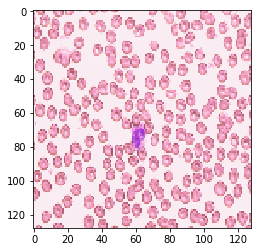

In [7]:
plt.imshow(image)

# 2. Jak wyglądają poszczególne warstwy, kanały rgb? 

In [8]:
r = image_arr.copy()
# set green and red channels to 0
r[:, :, 1] = 0
r[:, :, 2] = 0

g = image_arr.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

b = image_arr.copy()
# set blue and green channels to 0
b[:, :, 0] = 0
b[:, :, 1] = 0

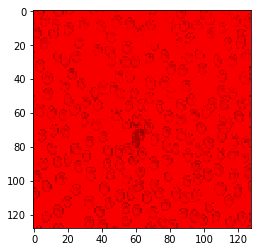

In [9]:
plt.imshow(r)

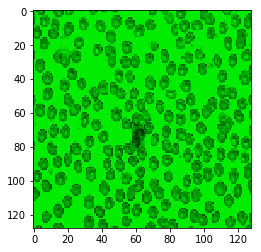

In [10]:
plt.imshow(g)

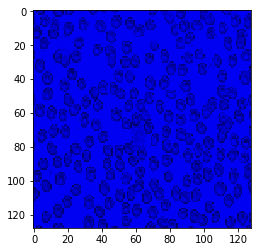

In [11]:
plt.imshow(b)

## 3. Transformacja do grafu ##

Następnie przystępujemy do budowy grafów $G_r, G_g, G_b$ reprezentujących warstwy obrazu.

**Opis konstrukcji**: wierzchołki to piksele, krawędź łącząca sąsiednie piksele $p_1, p_2$ ma wagę $d(p_1, p_2) = abs(w(p_1) - w(p_2))$, istnieje jeśli $d \leq p$, gdzie $p$ to wyznaczona przez autora *granica*.

In [12]:
# User może zdefiniować jaka jest granica
p = 15

In [13]:
def init_graphs():
    graph_r = nx.Graph()
    graph_g = nx.Graph()
    graph_b = nx.Graph()
    
    return graph_r, graph_g, graph_b

Definiowanie zbiorów wierzchołków grafów $G_r, G_g, G_b$

In [14]:
def define_nodes(graph, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            graph.add_node((i, j)) # wierzchołki to pary (i,j)

Definiowanie zbiorów krawędzi grafów $G_r, G_g, G_b$ przy uwzględnieniu granicy $p$.

In [15]:
def define_edges(graph, channel, shape, p):
    for i in range(shape[0]):
        for j in range(shape[1]):
            # badamy wcześniejszych sąsiadów piksela (i,j)
            if i - 1 >= 0 and abs(channel[i][j] - channel[i-1][j]) <= p:
                graph.add_edge((i, j), (i-1, j), weight=abs(channel[i][j] - channel[i-1][j]))

            if j - 1 >= 0 and abs(channel[i][j] - channel[i][j-1]) <= p:
                graph.add_edge((i, j), (i, j-1), weight=abs(channel[i][j] - channel[i][j-1]))

## 4. Inna metoda wizualizacji efektu segmentacji ##

Biorę kolejne komponenty, wyliczam średnią wartość piksela dla danego komponentu i nanoszę na kolejne channele RGB.

In [16]:
def get_result_channel(channel, two_connected_components):

    result = np.full(channel.shape, 255)

    for component in two_connected_components:
        num_of_pixels = len(component)
        value_acc = 0.0
        for pair in component:
            value_acc += channel[pair[0]][pair[1]]

        avg_value = value_acc / num_of_pixels # średnia wartość piksela, będzie to kolor reprezentujący dany segment

        avg_value = int(avg_value)
        for pair in component:
            result[pair[0]][pair[1]] = avg_value
            
    return result

## 5. Powyższe funkcje są składowymi następującego pipeline'a ##
Poniższa funkcja przyjmuje jako argumenty ścieżkę do obrazu, wartość graniczną $p$ oraz wymiary wyjściowego obrazu.

In [17]:
def two_connected_pipeline(image_path, p, shape):
    image = Image.open(image_path)
    
    image = image.resize(shape)
    image_arr = np.array(image, dtype='int16')
    
    channel_r = image_arr[:,:,0] 
    channel_g = image_arr[:,:,1]
    channel_b = image_arr[:,:,2]
    
    graph_r, graph_g, graph_b = init_graphs()
    
    define_nodes(graph_r, shape)
    define_nodes(graph_g, shape)
    define_nodes(graph_b, shape)
    
    define_edges(graph_r, channel_r, shape, p)
    define_edges(graph_g, channel_g, shape, p)
    define_edges(graph_b, channel_b, shape, p)
    
    k_components_r = apxa.k_components(graph_r)
    k_components_g = apxa.k_components(graph_g)
    k_components_b = apxa.k_components(graph_b)
    
    two_connected_components_r = k_components_r[2]
    two_connected_components_g = k_components_g[2]
    two_connected_components_b = k_components_b[2]
    
    print(len(two_connected_components_r))
    print(len(two_connected_components_g))
    print(len(two_connected_components_b))
    
    r_result = get_result_channel(channel_r, two_connected_components_r)
    g_result = get_result_channel(channel_g, two_connected_components_g)
    b_result = get_result_channel(channel_b, two_connected_components_b)
    
    result = np.zeros((shape[0], shape[1], 3))
    result[:,:,0] = r_result
    result[:,:,1] = g_result
    result[:,:,2] = b_result
    result = np.array(result, dtype='int16')
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(image)
    figure.add_subplot(1,2,2)
    plt.imshow(result)
    plt.show(block=True)

In [18]:
shape = (256,256)

## 6. Rezultaty - 4 potencjalnych sąsiadów, kolorowe obrazy ##

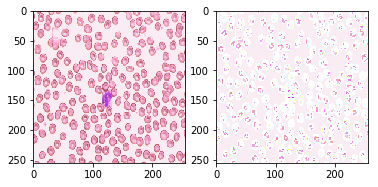

In [19]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_5.png")

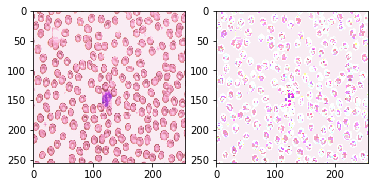

In [20]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_10.png")

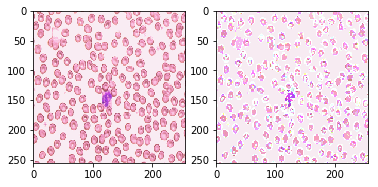

In [21]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_15.png")

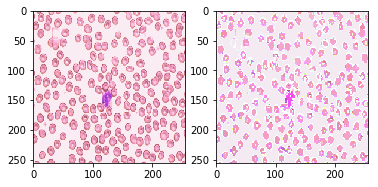

In [22]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_20.png")

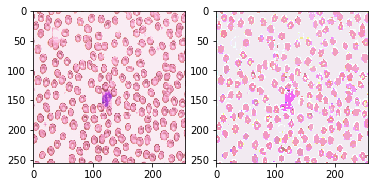

In [23]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_25.png")

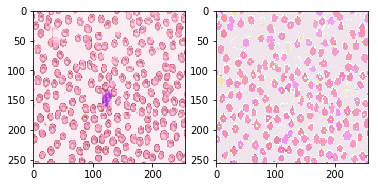

In [24]:
Image.open("./k_spojnosc_wyniki/red_blood_cells_30.png")

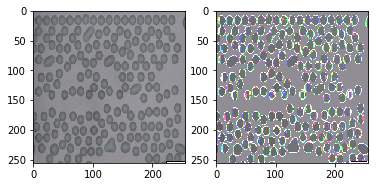

In [25]:
Image.open("./k_spojnosc_wyniki/blood_cells_5.png")

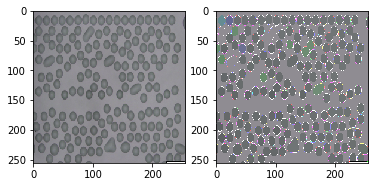

In [26]:
Image.open("./k_spojnosc_wyniki/blood_cells_10.png")

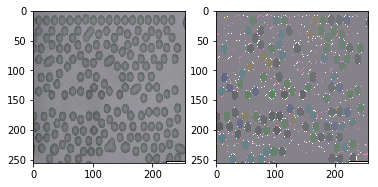

In [27]:
Image.open("./k_spojnosc_wyniki/blood_cells_15.png")

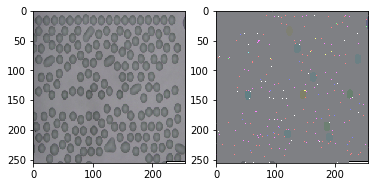

In [28]:
Image.open("./k_spojnosc_wyniki/blood_cells_20.png")

## 7. Rozważamy wersję z 8 sąsiadami - mój komputer to przerosło obliczeniowo :<

In [29]:
def define_edges(graph, channel, shape, p):
    for i in range(shape[0]):
        for j in range(shape[1]):
            # badamy wcześniejszych sąsiadów piksela (i,j)
            if i - 1 >= 0 and abs(channel[i][j] - channel[i-1][j]) <= p:
                graph.add_edge((i, j), (i-1, j), weight=abs(channel[i][j] - channel[i-1][j]))

            if j - 1 >= 0 and abs(channel[i][j] - channel[i][j-1]) <= p:
                graph.add_edge((i, j), (i, j-1), weight=abs(channel[i][j] - channel[i][j-1]))

            if i - 1 >= 0 and j - 1 >= 0 and abs(channel[i][j] - channel[i-1][j-1]) <= p:
                graph.add_edge((i, j), (i-1, j-1), weight=abs(channel[i][j] - channel[i-1][j-1]))

            if i - 1 >= 0 and j + 1 < image_arr.shape[1] and abs(channel[i][j] - channel[i-1][j+1]) <= p:
                graph.add_edge((i, j), (i-1, j+1), weight=abs(channel[i][j] - channel[i-1][j+1]))

In [30]:
def two_connected_pipeline(image_path, p, shape):
    image = Image.open(image_path)
    
    image = image.resize(shape)
    image_arr = np.array(image, dtype='int16')
    
    channel_r = image_arr[:,:,0] 
    channel_g = image_arr[:,:,1]
    channel_b = image_arr[:,:,2]
    
    graph_r, graph_g, graph_b = init_graphs()
    
    define_nodes(graph_r, shape)
    define_nodes(graph_g, shape)
    define_nodes(graph_b, shape)
    
    define_edges(graph_r, channel_r, shape, p)
    define_edges(graph_g, channel_g, shape, p)
    define_edges(graph_b, channel_b, shape, p)
    
    k_components_r = apxa.k_components(graph_r)
    k_components_g = apxa.k_components(graph_g)
    k_components_b = apxa.k_components(graph_b)
    
    two_connected_components_r = k_components_r[2]
    two_connected_components_g = k_components_g[2]
    two_connected_components_b = k_components_b[2]
    
    print(len(two_connected_components_r))
    print(len(two_connected_components_g))
    print(len(two_connected_components_b))
    
    r_result = get_result_channel(channel_r, two_connected_components_r)
    g_result = get_result_channel(channel_g, two_connected_components_g)
    b_result = get_result_channel(channel_b, two_connected_components_b)
    
    result = np.zeros((shape[0], shape[1], 3))
    result[:,:,0] = r_result
    result[:,:,1] = g_result
    result[:,:,2] = b_result
    result = np.array(result, dtype='int16')
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(image)
    figure.add_subplot(1,2,2)
    plt.imshow(result)
    plt.show(block=True)

In [31]:
shape = (256,256)

In [32]:
#two_connected_pipeline("./red_blood_cells.png", 30, shape)

## 8. k-spójność zdjęć w skali szarości

In [33]:
def define_edges(graph, channel, shape, p):
    for i in range(shape[0]):
        for j in range(shape[1]):
            if i - 1 >= 0 and abs(channel[i][j] - channel[i-1][j]) <= p:
                graph.add_edge((i, j), (i-1, j), weight=abs(channel[i][j] - channel[i-1][j]))
            if j - 1 >= 0 and abs(channel[i][j] - channel[i][j-1]) <= p:
                graph.add_edge((i, j), (i, j-1), weight=abs(channel[i][j] - channel[i][j-1]))

In [34]:
def two_connected_pipeline_grayscale(image,p, shape):
    image = image.resize(shape)
    image_arr = np.array(image, dtype='int16')
    
    graph1 = nx.Graph()
    
    define_nodes(graph1, shape)
    
    define_edges(graph1, image_arr, shape, p)
    
    k_components = apxa.k_components(graph1)
    
    two_connected_components = k_components[2]
    
    print(len(two_connected_components))
    
    result = get_result_channel(image_arr, two_connected_components)
    
    result = np.array(result, dtype='int16')
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(image)
    figure.add_subplot(1,2,2)
    plt.imshow(result)
    plt.show(block=True)

In [35]:
img = cv2.imread('blood_cells.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
new_im = Image.fromarray(gray)

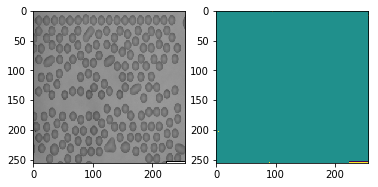

In [36]:
#two_connected_pipeline_grayscale(new_im,30, shape) => 2
Image.open("./k_spojnosc_wyniki/blood_cells_grayscale_30.png")

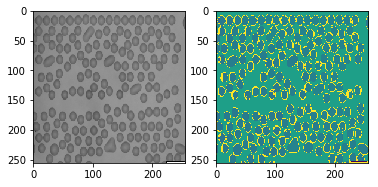

In [37]:
#two_connected_pipeline_grayscale(new_im,5, shape) => 286
Image.open("./k_spojnosc_wyniki/blood_cells_grayscale_5.png")

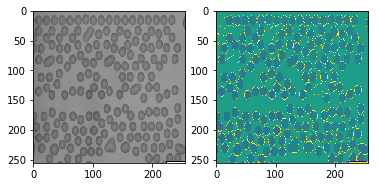

In [38]:
#two_connected_pipeline_grayscale(new_im,10, shape)=>183
Image.open("./k_spojnosc_wyniki/blood_cells_grayscale_10.png")

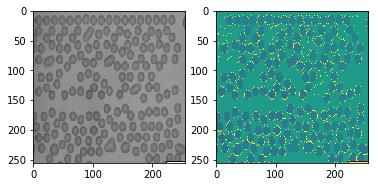

In [39]:
#two_connected_pipeline_grayscale(new_im,11, shape) => 174
Image.open("./k_spojnosc_wyniki/blood_cells_grayscale_11.png")

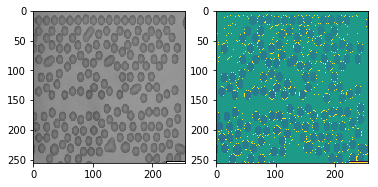

In [40]:
#two_connected_pipeline_grayscale(new_im,12, shape) => 159
Image.open("./k_spojnosc_wyniki/blood_cells_grayscale_12.png")

In [41]:
img = cv2.imread('red_blood_cells.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
new_im = Image.fromarray(gray)

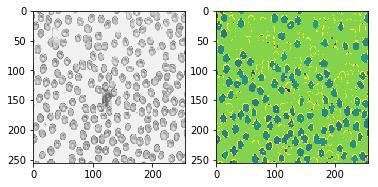

In [42]:
#two_connected_pipeline_grayscale(new_im,30, shape) => 245
Image.open("./k_spojnosc_wyniki/red_blood_cells_grayscale_30.png")

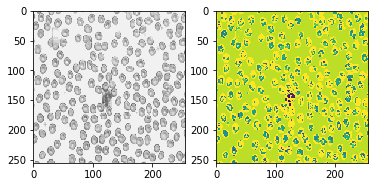

In [43]:
#two_connected_pipeline_grayscale(new_im,10, shape) => 1053
Image.open("./k_spojnosc_wyniki/red_blood_cells_grayscale_10.png")

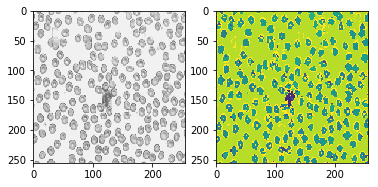

In [44]:
#two_connected_pipeline_grayscale(new_im,20, shape) => 524
Image.open("./k_spojnosc_wyniki/red_blood_cells_grayscale_20.png")

## 9. k-spójność zdjęć w postaci binarnej - najlepsza możliwa opcja :)

W przypadku binarnym nie rozważamy progu p, bo każdy piksel ma wartość 0 lub 255, wystarczy więc, by wartości były równe (dla każdego progu p efekt końcowy byłby taki sam).

In [45]:
def define_edges(graph, channel, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            # badamy wcześniejszych sąsiadów piksela (i,j)
            if i - 1 >= 0 and channel[i][j] == channel[i-1][j]:
                graph.add_edge((i, j), (i-1, j), weight=channel[i][j])
            if j - 1 >= 0 and channel[i][j] == channel[i][j-1]:
                graph.add_edge((i, j), (i, j-1), weight=channel[i][j])

In [46]:
def two_connected_pipeline_binary(image, shape):
    image = image.resize(shape)
    image_arr = np.array(image, dtype='int16')
    
    graph1 = nx.Graph()
    
    define_nodes(graph1, shape)
    
    define_edges(graph1, image_arr, shape)
    
    k_components = apxa.k_components(graph1)
    
    two_connected_components = k_components[2]
    
    print(len(two_connected_components))
    
    result = get_result_channel(image_arr, two_connected_components)
    
    result = np.array(result, dtype='int16')
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(image)
    figure.add_subplot(1,2,2)
    plt.imshow(result)
    plt.show(block=True)

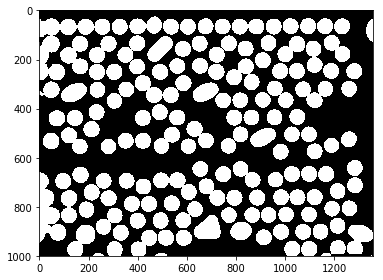

In [47]:
img = cv2.imread('blood_cells.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(thresh,[cnt],0,255,-1)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
new_im = Image.fromarray(opening)
io.imshow(opening)

In [48]:
shape = (256,256)

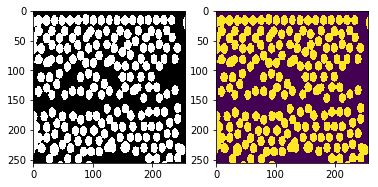

In [49]:
#two_connected_pipeline_binary(new_im, shape) => 158
Image.open("./k_spojnosc_wyniki/blood_cells_binary.png")

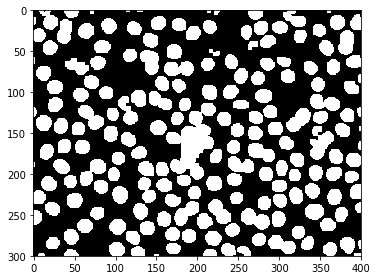

In [50]:
img = cv2.imread('red_blood_cells.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(thresh,[cnt],0,255,-1)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
new_im = Image.fromarray(opening)
io.imshow(opening)

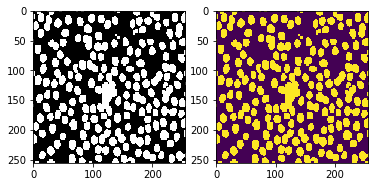

In [51]:
#two_connected_pipeline_binary(new_im, shape) => 192
Image.open("./k_spojnosc_wyniki/red_blood_cells_binary.png") 

# 10. k-spójność zdjęć w postaci binarnej - bez wypełniania dziur

In [52]:
img = cv2.imread('blood_cells.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
new_im = Image.fromarray(thresh)

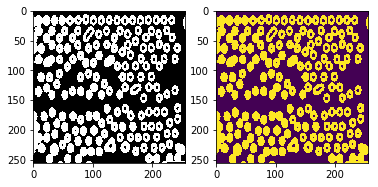

In [53]:
#two_connected_pipeline_binary(new_im, shape)=>257
Image.open("./k_spojnosc_wyniki/blood_cells_binary_with_holes.png") 

In [54]:
img = cv2.imread('red_blood_cells.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
new_im = Image.fromarray(thresh)

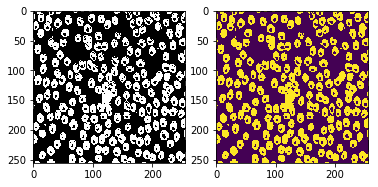

In [55]:
#two_connected_pipeline_binary(new_im, shape)=>418
Image.open("./k_spojnosc_wyniki/red_blood_cells_binary_with_holes.png") 

# 11. k-spójność zdjęć w postaci binarnej - 8 sąsiadów - ponownie mój komputer sobie z tym nie poradził :(

In [56]:
def define_edges(graph, channel, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            # badamy wcześniejszych sąsiadów piksela (i,j)
            if i - 1 >= 0 and channel[i][j] == channel[i-1][j]:
                graph.add_edge((i, j), (i-1, j), weight=channel[i][j])
            if j - 1 >= 0 and channel[i][j] == channel[i][j-1]:
                graph.add_edge((i, j), (i, j-1), weight=channel[i][j])
            if i - 1 >= 0 and j - 1 >= 0 and channel[i][j] == channel[i-1][j-1]:
                graph.add_edge((i, j), (i-1, j-1), weight=channel[i][j])
            if i - 1 >= 0 and j + 1 < image_arr.shape[1] and channel[i][j] == channel[i-1][j+1]:
                graph.add_edge((i, j), (i-1, j+1), weight=channel[i-1][j+1])

In [57]:
img = cv2.imread('blood_cells.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(thresh,[cnt],0,255,-1)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
new_im = Image.fromarray(opening)

In [58]:
#two_connected_pipeline_binary(new_im, shape)